## Use MetaCLIP2 for Image Search

Have you ever wondered how text search in your gallery works?

Meta released MetaCLIP2, a model that can understand both text and images in many languages! In this notebook we will use it on free GPU to search images from text queries.

![](https://huggingface.co/datasets/merve/vlm_test_images/resolve/main/image_search.png)

Typical workflow is the following:

1 **Offline Indexing:** Pass all your images through the model's image part and keep indexed image embeddings in a vector DB (so you know which embedding is which image). This is done once, hence called offline indexing, and takes time.

2.1. **Online Inference:** Pass the text query through model's text part to get the query text embedding.

2.2. **Similarity & Look-up:** Run similarity between the text embedding and image embeddings and get the most similar image embedding, then look-up from the vector DB.

Let's install packages, download MetaCLIP2 and my dataset (which is bunch of food images). We'll use FAISS-GPU to keep our images.

In [ ]:
!pip install -q faiss-gpu-cu12

In [1]:
from datasets import load_dataset

ds = load_dataset("merve/food")

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 16
    })
})

Let's load the model. FAISS accepts vectors as float32 so we load the model in that precision.

In [ ]:
import torch
from transformers import AutoProcessor, AutoModel, infer_device


device = infer_device()
model = AutoModel.from_pretrained("facebook/metaclip-2-worldwide-giant", torch_dtype=torch.float32, attn_implementation="sdpa").to(device)
processor = AutoProcessor.from_pretrained("facebook/metaclip-2-worldwide-giant")

Dataset indexing function ⤵️ Here we just load the image, preprocess and pass through model to get the embedding. After, we return embedding as list so we can pass it to FAISS.

We initialize the index and embed images and add vector to the index. We initialize the index with the projection dim we find in the model configuration.

In [8]:
model.config.projection_dim

1280

In [7]:
import torch
import faiss
import numpy as np

def add_vector(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

def embed_metaclip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features


index = faiss.IndexFlatL2(1280)

for elem in ds["train"]:
  clip_features = embed_metaclip(elem["image"])
  add_vector(clip_features,index)

Now we write online inference. Basically we will take a text prompt and find closest k number of images in our indexed database.

In [10]:
prompt="an ice-cream"

text_token = processor.tokenizer([prompt], return_tensors="pt").to(device)
text_features = model.get_text_features(**text_token)

text_features = text_features.detach().cpu().numpy()
text_features = np.float32(text_features)
faiss.normalize_L2(text_features)

distances, indices = index.search(text_features, 3)
indices

array([[15,  1,  4]])

Let's put all of these to action now. We will encode our dataset, create the index, write it to FAISS. Optionally you can choose to save the FAISS DB.

Then we will search our queries and find best images.

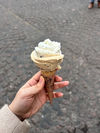

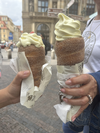

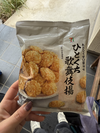

In [18]:
from PIL import Image
for elem in indices[0]:
  elem = int(elem)
  image = ds["train"][elem]["image"]

  # downscale
  width = 100
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  display(img)

In our gallery there were only two ice cream images, but since we asked the model to return 3 results, it returned an irrelevant image. We can filter them out using "distance" which is how far the image to the text query is. As you can see, it's the farthest one.

In [17]:
distances

array([[1.6205274, 1.6923535, 1.7776461]], dtype=float32)

One cool thing is that this model can do it in multiple languages as well. As you can see it returns the same result when given the same query in French.

In [19]:
prompt="une glace"

text_token = processor.tokenizer([prompt], return_tensors="pt").to(device)
text_features = model.get_text_features(**text_token)

text_features = text_features.detach().cpu().numpy()
text_features = np.float32(text_features)
faiss.normalize_L2(text_features)

distances, indices = index.search(text_features, 3)
indices

array([[15,  1,  4]])